- [memory leek on second attempt](https://github.com/huggingface/diffusers/issues/4164)

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
from diffusers import StableDiffusionXLPipeline, AutoencoderKL

path = "stabilityai/stable-diffusion-xl-base-1.0"
vae_path = "madebyollin/sdxl-vae-fp16-fix"
device = 'cuda:0'
generator = torch.Generator(device)


vae = AutoencoderKL.from_pretrained(vae_path, torch_dtype=torch.float16)
pipe = StableDiffusionXLPipeline.from_pretrained(path, torch_dtype=torch.float16, vae=vae, variant="fp16", use_safetensors=True, local_files_only=True, add_watermarker=False)
pipe.to(device);


# Data generation

In [26]:
# prompt = "An astronaut riding a green horse on Mars"
# steps = 10

# for _ in range(2):
#     generator.manual_seed(1337)
#     image = pipe(prompt=prompt, num_inference_steps=steps, generator=generator).images[0]
#     size = (np.array(image.size) / 4).astype(int).tolist()
#     display(image.resize(size))


In [54]:
import random

def generate_salient_object_prompts(num_prompts, seed=None):
    if seed is not None:
        random.seed(seed)

    sizes = ['tiny', 'small', 'medium', 'big']
    objects = ['flower', 'person', 'building', 'tree', 'octopus']
    positions = ['left part', 'right part', 'bottom part', 'upper part', 'the center']
    environments = ['home', 'water', 'street']

    prompts = []
    for i in range(num_prompts):
        size = random.choice(sizes)
        object = random.choice(objects)
        position = random.choice(positions)
        environment = random.choice(environments)
        prompt = f"Image of {size} size {object} in the {position} of the image in {environment}."
        prompts.append(prompt)
    return prompts


prompts = generate_salient_object_prompts(20, seed=10)
prompts

['Image of tiny size tree in the upper part of the image in street.',
 'Image of tiny size person in the upper part of the image in water.',
 'Image of medium size person in the left part of the image in street.',
 'Image of big size building in the left part of the image in home.',
 'Image of medium size flower in the upper part of the image in home.',
 'Image of medium size tree in the upper part of the image in water.',
 'Image of medium size tree in the right part of the image in street.',
 'Image of medium size building in the right part of the image in water.',
 'Image of small size tree in the the center of the image in water.',
 'Image of tiny size octopus in the left part of the image in home.',
 'Image of small size person in the bottom part of the image in street.',
 'Image of medium size person in the bottom part of the image in street.',
 'Image of big size tree in the upper part of the image in home.',
 'Image of medium size octopus in the right part of the image in home.

In [55]:
from pathlib import Path

data_path = Path('data')
img_path = data_path / 'img'
img_path.mkdir(exist_ok=True, parents=True)


Total images:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of tiny size tree in the upper part of the image in street.


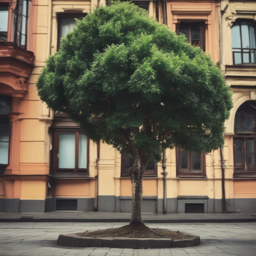

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of tiny size person in the upper part of the image in water.


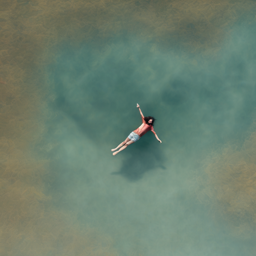

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of medium size person in the left part of the image in street.


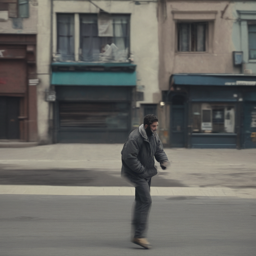

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of big size building in the left part of the image in home.


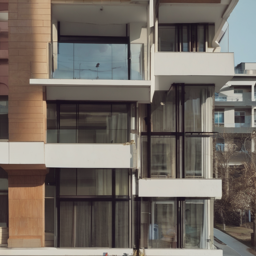

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of medium size flower in the upper part of the image in home.


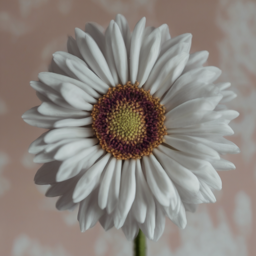

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of medium size tree in the upper part of the image in water.


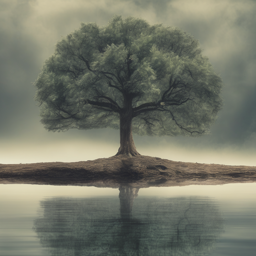

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of medium size tree in the right part of the image in street.


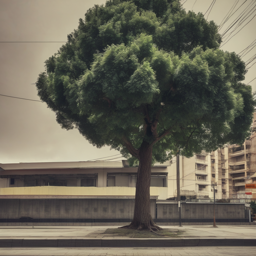

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of medium size building in the right part of the image in water.


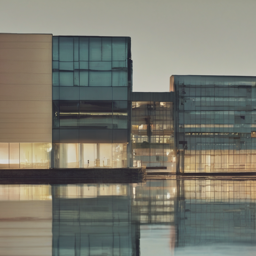

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of small size tree in the the center of the image in water.


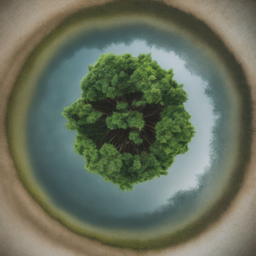

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of tiny size octopus in the left part of the image in home.


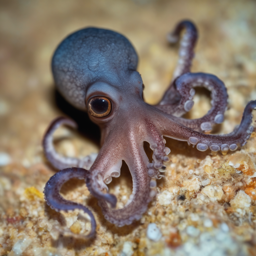

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of small size person in the bottom part of the image in street.


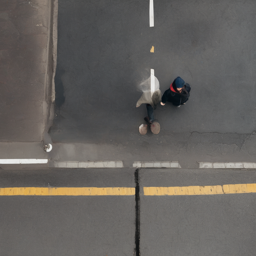

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of medium size person in the bottom part of the image in street.


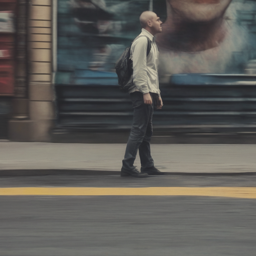

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of big size tree in the upper part of the image in home.


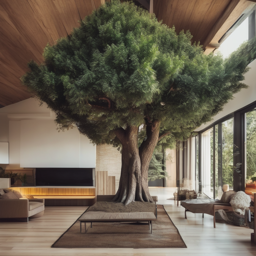

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of medium size octopus in the right part of the image in home.


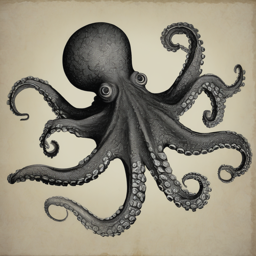

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of big size person in the left part of the image in home.


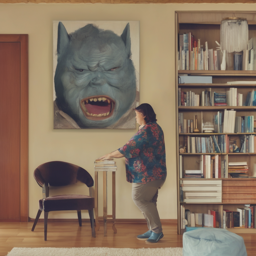

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of big size building in the the center of the image in street.


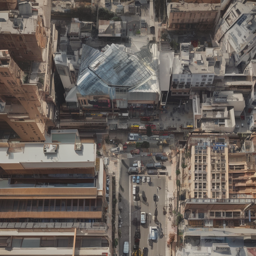

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of tiny size octopus in the left part of the image in home.


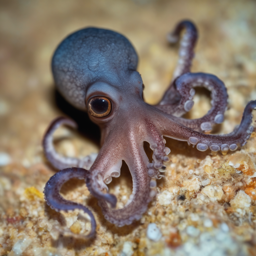

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of big size octopus in the bottom part of the image in street.


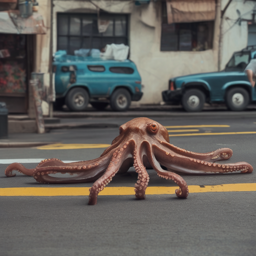

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of small size flower in the left part of the image in water.


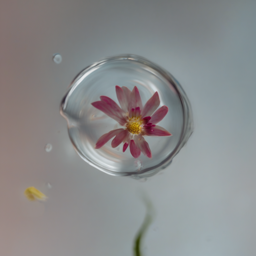

  0%|          | 0/50 [00:00<?, ?it/s]

prompt: Image of small size person in the bottom part of the image in water.


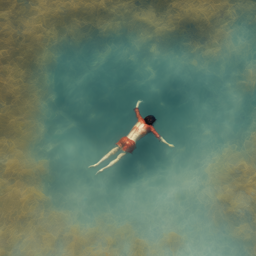

In [56]:
data = []
steps = 50

for i, prompt in enumerate(tqdm(prompts, desc='Total images')):
    seed = 1337
    generator.manual_seed(seed)
    image = pipe(prompt=prompt, num_inference_steps=steps, generator=generator).images[0]
    size = (np.array(image.size) / 4).astype(int).tolist()
    print(f'prompt: {prompt}')
    display(image.resize(size))

    out_path = str(img_path / f'{i}.png')
    data.append([out_path, seed, prompt, steps])
    image.save(out_path)
    

In [ ]:
data = pd.DataFrame(data, columns=['img_path', 'seed', 'prompt', 'num_inference_steps'])
info_path = str(data_path / 'info.csv')
data.to_csv(info_path)

data

# Load data

In [ ]:
from utils import imread, imshow, imsshow

data = pd.read_csv('data/info.csv')
imgs = [imread(img_path) for img_path in data.img_path]
imsshow(imgs, titles = data.prompt)